In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [0]:
train_data = datasets.ImageFolder('/content/gdrive/My Drive/car_types',transform=transform)


In [0]:
batch_size = 32
test_size = 0.3
valid_size = 0.1

#For test
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]


#For Valid
num_train = len(train_idx)
indices_train = train_idx
split_tv = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]



train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#Loaders contains the data in tuple format 
# (Image in form of tensor, label)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(train_data, sampler = test_sampler, batch_size=batch_size,num_workers=1)

# variables representing classes of the images
classes = ['coupe' , 'sedan', 'suv', 'truck']

In [7]:
len(test_loader)*batch_size + len(valid_loader)*batch_size + len(train_loader)*batch_size


60928

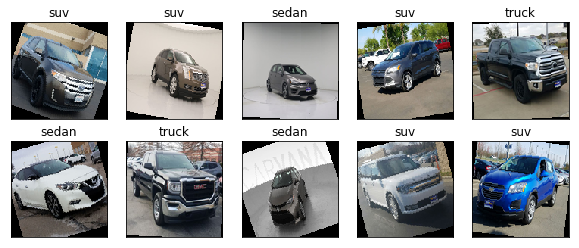

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*29*29, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 4)
        self.softmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

True
Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=26912, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (softmax): LogSoftmax()
)


In [0]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [0]:
# number of epochs
n_epochs = 50 

valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    # train
    model.train()
    count = 0
    for data, target in train_loader:
        count = count + 1
        if (count % 100 == 0):
          print(count)
          
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass
        loss.backward()
        # perform a single optimization step 
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # validate
    model.eval()
    for data, target in valid_loader:
      
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/content/gdrive/My Drive/model_final.pt')
        valid_loss_min = valid_loss

100
200
300
400
500
600
700
800
900
1000
1100
Epoch: 1 	Training Loss: 0.542745 	Validation Loss: 0.052823
Validation loss decreased (inf --> 0.052823).  Saving model ...
100
200
300
400
500
600
700
800
900
1000
1100
Epoch: 2 	Training Loss: 0.425556 	Validation Loss: 0.043253
Validation loss decreased (0.052823 --> 0.043253).  Saving model ...
100
200
300
400
500
600
700
800
900
1000
1100
Epoch: 3 	Training Loss: 0.364231 	Validation Loss: 0.035673
Validation loss decreased (0.043253 --> 0.035673).  Saving model ...
100
200
300
400
500
600
700
800
900
1000
1100
Epoch: 4 	Training Loss: 0.314871 	Validation Loss: 0.031012
Validation loss decreased (0.035673 --> 0.031012).  Saving model ...
100
200
300
400
500
600
700
800
900
1000
1100
Epoch: 5 	Training Loss: 0.273185 	Validation Loss: 0.028237
Validation loss decreased (0.031012 --> 0.028237).  Saving model ...
100
200
300
400
500
600
700
800
900
1000
1100
Epoch: 6 	Training Loss: 0.242864 	Validation Loss: 0.026434
Validation loss de

In [0]:
model = Net()
model.load_state_dict(torch.load('/content/gdrive/My Drive/model_final.pt'))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=26912, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
for data, target in test_loader:
  output = model(data)
  print(output)

tensor([[-3.6406e-01, -1.1869e+00],
        [-2.5784e-01, -1.4816e+00],
        [-3.7074e-01, -1.1719e+00],
        [-4.7249e-01, -9.7670e-01],
        [-2.5211e-01, -1.5013e+00],
        [-2.3582e-03, -6.0511e+00],
        [-5.9860e-03, -5.1213e+00],
        [-8.4736e-02, -2.5103e+00],
        [-1.3252e-01, -2.0866e+00],
        [-6.0916e-04, -7.4038e+00],
        [-3.0849e-03, -5.7828e+00],
        [-8.1058e-03, -4.8192e+00],
        [-3.3641e-01, -1.2529e+00],
        [-3.8119e-02, -3.2860e+00],
        [-2.7996e-01, -1.4098e+00],
        [-5.9583e-03, -5.1259e+00],
        [-8.3542e-04, -7.0881e+00],
        [-3.9642e-01, -1.1169e+00],
        [-3.1308e-01, -1.3138e+00],
        [-4.5962e-03, -5.3848e+00],
        [-3.6805e-03, -5.6066e+00],
        [-2.7205e-01, -1.4347e+00],
        [-4.8537e-01, -9.5573e-01],
        [-8.4829e-04, -7.0727e+00],
        [-3.1730e-01, -1.3024e+00],
        [-3.8409e-01, -1.1428e+00],
        [-4.1836e-01, -1.0733e+00],
        [-4.7750e-01, -9.684

KeyboardInterrupt: ignored

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
model.cuda()
model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    
    # calculate test accuracy for each object class
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.036743

Test Accuracy of coupe: 66% (460/693)
Test Accuracy of sedan: 96% (6855/7105)
Test Accuracy of   suv: 98% (9319/9430)
Test Accuracy of truck: 90% (912/1012)

Test Accuracy (Overall): 96% (17546/18240)
